# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv_5_4.

<img src='https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/vgg19_convlayers.png?raw=1' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/notebook_ims/style_tx_cat.png?raw=1' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [0]:
#@title
#ORGINAL LINK IS BELOW
#https://github.com/iceman011/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb

# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models
import time
from io import BytesIO as _BytesIO


##############################################
# PAREPARE VGG PRETRAINED MODEL
############################################
def prepare_model():
  # get the "features" portion of VGG19 (we will not need the "classifier" portion)
  vgg = models.vgg19(pretrained=True).features

  # freeze all VGG parameters since we're only optimizing the target image
  for param in vgg.parameters():
      param.requires_grad_(False)
  print('Finished Preparing Model...')
  return vgg

##########################################
# GET FEATURES FROM VGG MODEL
##############################################
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

#############################################
# BUILD GRAM MATRIX
#############################################
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

###############################################
# iniTIALIZE WEIGHTS
###############################################
def init_weights(style_weights=None,content_weight =1, style_weight=1e6):
  # weights for each style layer 
  # weighting earlier layers more will result in *larger* style artifacts
  # notice we are excluding `conv4_2` our content representation
  if not style_weights:
    style_weights = {'conv1_1': 1.,#1.,
                    'conv2_1': 0.75,
                    'conv3_1': 0.2,
                    'conv4_1': 0.2,
                    'conv5_1': 0.2}

  content_weight = content_weight # alpha
  style_weight = style_weight  # beta
  return style_weights , content_weight , style_weight

#####################################
# BUILD CONENT & STYLE FEATURES
######################################
def build_features(content ,style,model):
  # get content and style features only once before training
  content_features = get_features(content, model)
  style_features = get_features(style, model)
  return content_features , style_features

#####################################
# CALC GRAMS OF STYLE FEATURES
######################################
def calc_style_grams(style_features):
  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
  return style_grams

#####################################
# LOAD IMAGE FROM LOCAL OR WEB ADSRESS
######################################
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image      

##########################################
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
##########################################
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


##########################################
# helper function to convert PIL image to base64 for HTML display
##########################################
def pil_to_b64(im, enc_format='png', verbose=True, **kwargs):
    """
    Converts a PIL Image into base64 string for HTML displaying
    :param im: PIL Image object
    :param enc_format: The image format for displaying. If saved the image will have that extension.
    :return: base64 encoding
    """
    t_start = time.time()

    buff = _BytesIO()
    im.save(buff, format=enc_format, **kwargs)
    encoded = base64.b64encode(buff.getvalue()).decode("utf-8")

    t_end = time.time()
    if verbose:
        print(f"PIL converted to b64 in {t_end - t_start:.3f} sec")

    return encoded


##########################################
# helper function to convert numpy image to base64 for HTML display
##########################################
def numpy_to_b64(np_array, enc_format='png', scalar=True, **kwargs):
    """
    Converts a numpy image into base 64 string for HTML displaying
    :param np_array:
    :param enc_format: The image format for displaying. If saved the image will have that extension.
    :param scalar:
    :return:
    """
    # Convert from 0-1 to 0-255
    if scalar:
        np_array = np.uint8(255 * np_array)
    else:
        np_array = np.uint8(np_array)

    im_pil = Image.fromarray(np_array)

    return pil_to_b64(im_pil, enc_format, **kwargs)

#######################################
# DEBUG INTERMEDIATE STATES
###########################################
def view_target_featuers(target_featuers):
  fig = plt.figure(figsize=(10, 6))
  i = 0
  for layer_name in target_features:
    layer = target_features[layer_name]
    image = layer.to("cpu").clone().detach()
    image = image.numpy().squeeze()

    
    ax = fig.add_subplot(1, 6, i+1, xticks=[], yticks=[])
    
    ax.imshow(image[0,:,:])
    ax.set_title('LayerName %s' % layer_name)
    i+=1

    #fig, (ax1, ax2) = plt.subplots(1, 5, figsize=(20, 10))

#########################################################
# DISPLAY FINAL TARGET IN REGARD TO ORGINAL CONTENT & STYLE
##############################################################
def display_final(content,style,target):
  # display content and final, target image
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))
  ax3.imshow(im_convert(target))
  plt.show()

##############################################
# LOAD ORIGINAL CONTENT & STYLE IMAGES
##############################################
def load_original_images(content_image_path,style_image_path,device):
    # load in content and style image
  
  #content = load_image('https://www.laketobias.com/wp-content/uploads/bengal-tiger.jpg').to(device)
  content = load_image(content_image_path).to(device)
  
  # Resize style to match content, makes code easier
  style = load_image(style_image_path, shape=content.shape[-2:]).to(device)

  # display the images
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))
  plt.show()
  return content , style

##############################
# to handle double submit
##############################
gModel = None

##########################################
# STYLE TRANSFER TRAINING USING VGG
############################################
def train_style_transfer(model,device,content,content_features,content_weight,style,style_weights,style_grams,style_weight,lr=0.003,epochs=3000,show_every=100):
  
  print('Starting Training Style Transfer using content_weight {} , style_weight{} , lr {} , epochs {} , show_every {} '.format(content_weight,style_weight,lr,epochs,show_every))

  # create a third "target" image and prep it for change
  # it is a good idea to start off with the target as a copy of our *content* image
  # then iteratively change its style
  inner_images = []
  target = content.clone().requires_grad_(True).to(device)

  inner_images.append(im_convert(content))
  inner_images.append(im_convert(style))
  
  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=lr)

  for epoch in range(1, epochs+1):
      
      # get the features from your target image
      target_features = get_features(target, model)
      
      # the content loss
      content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
      
      # the style loss
      # initialize the style loss to 0
      style_loss = 0
      # then add to it for each layer's gram matrix loss
      for layer in style_weights:
          # get the "target" style representation for the layer
          target_feature = target_features[layer]
          target_gram = gram_matrix(target_feature)
          _, d, h, w = target_feature.shape
          # get the "style" style representation
          style_gram = style_grams[layer]
          # the style loss for one layer, weighted appropriately
          layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
          # add to the style loss
          style_loss += layer_style_loss / (d * h * w)
          
      # calculate the *total* loss
      total_loss = content_weight * content_loss + style_weight * style_loss
      
      # update your target image
      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()
      
      # display intermediate images and print the loss
      if  epoch % show_every == 0:
          print("Current Epoch: {} ,Content loss: {} ,Style loss:{}  ,Total loss: {}".format(epoch,content_loss,style_loss,total_loss.item()))
          target_numpy = im_convert(target)
          plt.imshow(target_numpy)
          plt.show()
          inner_images.append(target_numpy)
          #view_target_featuers(target_features)
  return target , inner_images   

#########################################
# RUN MODEL FUNCTION
############################################
def RunModel(content_image_path,style_image_path,content_weight_param,style_weight_param,lr=0.003,epochs=3000,show_every=100):
  
  global gModel
  # move the model to GPU, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  content , style = load_original_images(content_image_path,style_image_path,device)

  # display the images
  #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  #ax1.imshow(im_convert(content))
  #ax2.imshow(im_convert(style))
  #plt.show()

  gModel = prepare_model()
  gModel.to(device)
  style_weights , content_weight , style_weight =  init_weights(style_weights=None,content_weight =1, style_weight=1e6)

  if( content_weight_param is not None and content_weight_param != 0 ):
    content_weight = content_weight_param
  
  if( style_weight_param is not None and style_weight_param != 0 ):
    style_weight = style_weight_param
  
  content_features , style_features = build_features(content ,style,gModel)
  style_grams = calc_style_grams(style_features)

  target , inner_images = train_style_transfer(gModel,device,content,content_features,content_weight,style,style_weights,
                                style_grams,style_weight,lr=lr,epochs=epochs,show_every=show_every)
  inner_images.append(im_convert(target))
  display_final(content,style,target)
  
  return im_convert(target) , inner_images




#MAIN()

In [0]:
# How to run a Dash app in Google Colab
import base64
import os
from urllib.parse import quote as urlquote

from flask import Flask, send_from_directory


def init_dash_lib():
  ### Install ngrok
  
  !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
  !unzip ngrok-stable-linux-amd64.zip

  ### Install Dash
  #!pip uninstall dash
  !pip install dash #==0.31.1  # The core dash backend
  !pip install dash-html-components #==0.13.2  # HTML components
  !pip install dash-core-components #==0.39.0  # Supercharged components
  !pip install dash-table #==3.1.7  # Interactive DataTable component (new!)

def init_dash_server():

  # move the model to GPU, if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  ### Run ngrok to tunnel Dash app port 8050 to the outside world. 
  ### This command runs in the background.
  get_ipython().system_raw('./ngrok http 8050 &')

  ### Get the public URL where you can access the Dash app. Copy this URL.
  #print('PUBLIC IP.....')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

  # Normally, Dash creates its own Flask server internally. By creating our own,
  # we can create a route for downloading files directly:
  server = Flask(__name__)

  return server


if not os.path.exists('./ngrok-stable-linux-amd64.zip'):
  init_dash_lib()

server = init_dash_server()

https://edcc30df.ngrok.io


https://edcc30df.ngrok.io
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
InitGallery .... Final-Image : 1_Final.jpg 
PIL converted to b64 in 0.101 sec
InitGallery .... Final-Image : 2_Final.jpg 
PIL converted to b64 in 0.105 sec
InitGallery .... Final-Image : 3_Final.jpg 
PIL converted to b64 in 0.103 sec
InitGallery .... Final-Image : 4_Final.jpg 
PIL converted to b64 in 0.136 sec
InitGallery .... Final-Image : 5_Final.jpg 
PIL converted to b64 in 0.093 sec
InitGallery .... Final-Image : 6_Final.jpg 
PIL converted to b64 in 0.098 sec
InitGallery .... Final-Image : 7_Final.jpg 
PIL converted to b64 in 0.103 sec
InitGallery .... Final-Image : 8_Final.jpg 
PIL converted to b64 in 0.104 sec
InitGallery .... Final-Image : 9_Final.jpg 
PIL converted to b64 in 0.103 sec
InitGallery .... Final-Image : 10_Final.jpg 
PIL converted to b64 in 0.078 sec
InitGallery .... Final-Image : 21_Apr_2020_14_33_37_Final.jpg 

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Apr/2020 18:03:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:29] "GET /assets/style.css?m=1587656589.697363 HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:29] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_3_0m1587656759.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:30] "GET /_dash-component-suites/dash_renderer/react@16.v1_3_0m1587656759.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:30] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_3_0m1587656759.13.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:30] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_0_3m1587656761.min.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:30] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_3_0m1587656759.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:03:30] "GET /_dash-component-suites/dash_core_components

update_output None , resetbtn_click None , upload_dir_exist False 


127.0.0.1 - - [23/Apr/2020 18:03:45] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 1,style_weight_slider 4,learning_rate_slider 3, epochs_slider 2 ,show_every_slider 1 ,target_images_slider 0 


127.0.0.1 - - [23/Apr/2020 18:04:05] "POST /_dash-update-component HTTP/1.1" 200 -


update_output ['WhatsApp Image 2020-04-22 at 21.18.14.jpeg', 'zz.jpg'] , resetbtn_click None , upload_dir_exist False 
uploaded image index:  0  At Path:  ./cached_images/Original.jpg
display_original_images ....
uploaded image index:  1  At Path:  ./cached_images/Style.jpg
display_original_images ....


127.0.0.1 - - [23/Apr/2020 18:04:10] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 1,style_weight_slider 4,learning_rate_slider 3, epochs_slider 2 ,show_every_slider 1 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:04:17] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 1,style_weight_slider 4,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 1 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:04:19] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 1,style_weight_slider 4,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:04:24] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 4,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:04:26] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:04:30] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:04:32] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:09:30] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:09:30] "GET /_dash-component-suites/dash_core_components/async-upload.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:09:30] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:09:30] "GET /_dash-component-suites/dash_core_components/dash_core_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 18:09:31] "GET /_dash-component-suites/dash_core_components/async-slider.js.map HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 2 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False
record_new_exe -> exe_id mohamed.phd011@gmail.com ,user_email 23_Apr_2020_18_10_06 ,content_weight_slider 2 ,style_weight_slider 2 ,learning_rate_slider 0.003 ,epochs_slider 8000 ,show_every_slider 2000 


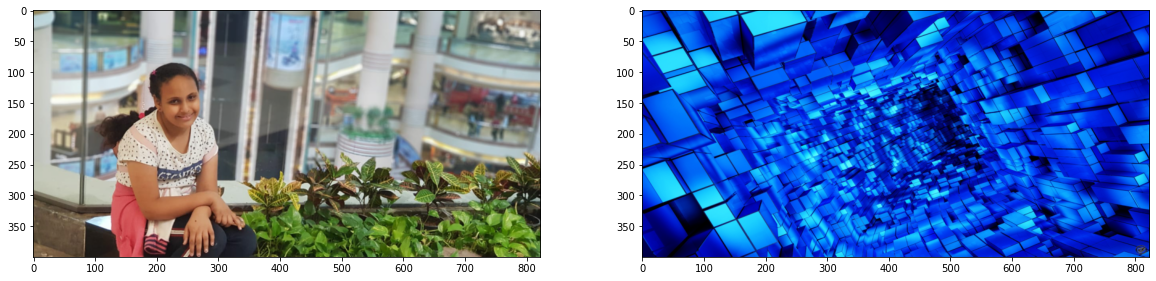

Finished Preparing Model...
Starting Training Style Transfer using content_weight 2 , style_weight2 , lr 0.003 , epochs 8000 , show_every 2000 
Current Epoch: 2000 ,Content loss: 14.397821426391602 ,Style loss:42.41204833984375  ,Total loss: 113.61973571777344


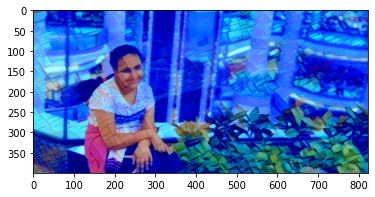

Current Epoch: 4000 ,Content loss: 12.63425350189209 ,Style loss:11.317924499511719  ,Total loss: 47.90435791015625


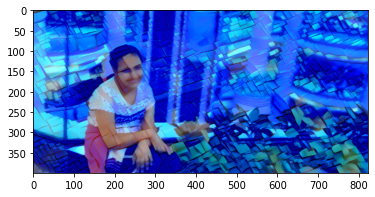

Current Epoch: 6000 ,Content loss: 11.305249214172363 ,Style loss:4.6351470947265625  ,Total loss: 31.88079261779785


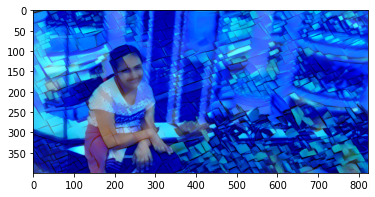

Current Epoch: 8000 ,Content loss: 10.342304229736328 ,Style loss:2.6043894290924072  ,Total loss: 25.893386840820312


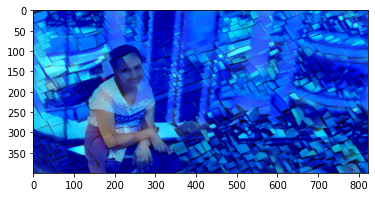

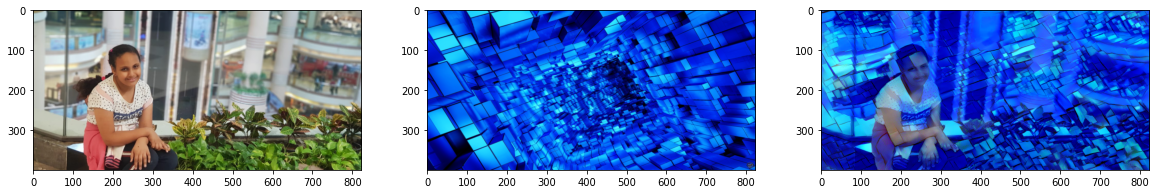

PIL converted to b64 in 0.136 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.130 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.104 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.099 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.097 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.093 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


127.0.0.1 - - [23/Apr/2020 18:27:20] "POST /_dash-update-component HTTP/1.1" 200 -


PIL converted to b64 in 0.095 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.094 sec


127.0.0.1 - - [23/Apr/2020 18:45:55] "POST /_dash-update-component HTTP/1.1" 200 -


update_output ['WhatsApp Image 2020-04-22 at 21.18.14.jpeg', 'zz.jpg'] , resetbtn_click 1 , upload_dir_exist True 


127.0.0.1 - - [23/Apr/2020 18:45:56] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email  ,finishUserInfoBtn 2 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:46:25] "POST /_dash-update-component HTTP/1.1" 200 -


update_output ['face6.jpg', '1.jpg'] , resetbtn_click 1 , upload_dir_exist False 
uploaded image index:  0  At Path:  ./cached_images/Original.jpg
display_original_images ....
uploaded image index:  1  At Path:  ./cached_images/Style.jpg
display_original_images ....


127.0.0.1 - - [23/Apr/2020 18:46:27] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email  ,finishUserInfoBtn 2 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 18:46:38] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 2 ,user_email  ,finishUserInfoBtn 2 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False
handle_start_image_style -> no_startBtn_click 2 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 2 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False
record_new_exe -> exe_id mohamed.phd011@gmail.com ,user_email 23_Apr_2020_18_46_41 ,content_weight_slider 2 ,style_weight_slider 2 ,learning_rate_slider 0.003 ,epochs_slider 8000 ,show_every_slider 2000 


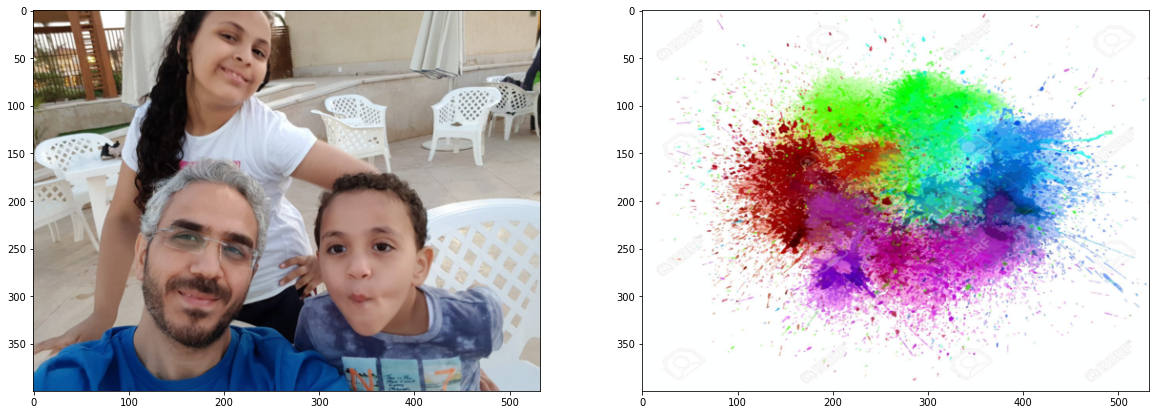

Finished Preparing Model...
Starting Training Style Transfer using content_weight 2 , style_weight2 , lr 0.003 , epochs 8000 , show_every 2000 
Current Epoch: 2000 ,Content loss: 3.670410394668579 ,Style loss:10.639424324035645  ,Total loss: 28.61966896057129


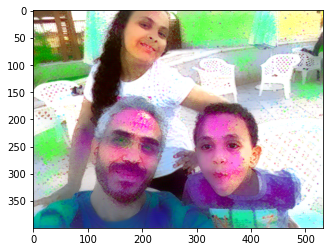

Current Epoch: 4000 ,Content loss: 3.239393711090088 ,Style loss:4.049820423126221  ,Total loss: 14.578428268432617


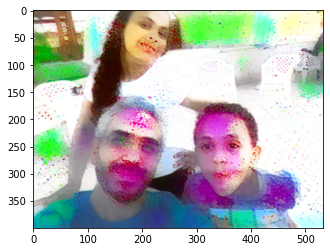

Current Epoch: 6000 ,Content loss: 2.9638073444366455 ,Style loss:2.429335594177246  ,Total loss: 10.786285400390625


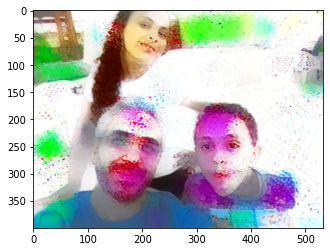

Current Epoch: 8000 ,Content loss: 2.7709801197052 ,Style loss:1.8128442764282227  ,Total loss: 9.167648315429688


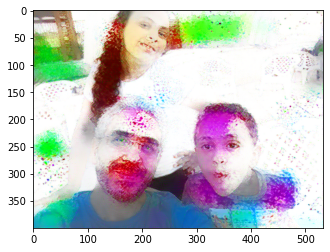

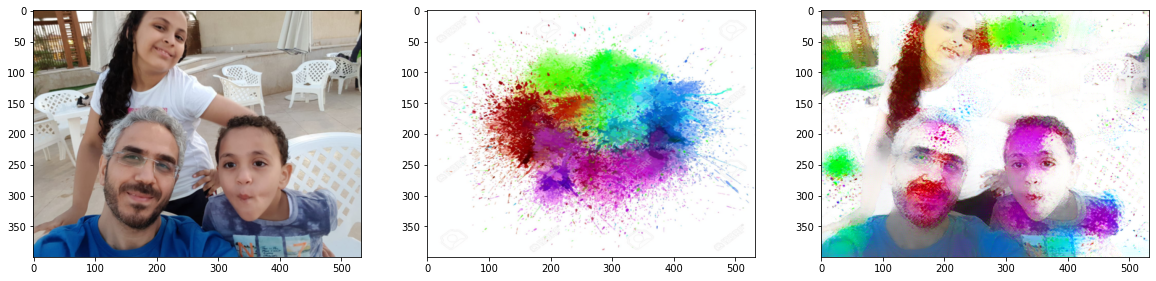

PIL converted to b64 in 0.159 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.050 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.048 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.050 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.046 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.047 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL conver

127.0.0.1 - - [23/Apr/2020 18:58:24] "POST /_dash-update-component HTTP/1.1" 200 -


PIL converted to b64 in 0.048 sec


127.0.0.1 - - [23/Apr/2020 19:04:16] "GET /_dash-component-suites/dash_core_components/dash_core_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:04:16] "GET /_dash-component-suites/dash_core_components/async-slider.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:04:16] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:04:16] "GET /_dash-component-suites/dash_core_components/async-upload.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:04:16] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.js.map HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:04:40] "POST /_dash-update-component HTTP/1.1" 200 -


update_output ['face6.jpg', '1.jpg'] , resetbtn_click 2 , upload_dir_exist True 


127.0.0.1 - - [23/Apr/2020 19:04:40] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 2 ,user_email  ,finishUserInfoBtn 2 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 4 ,show_every_slider 2 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:05:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:06:00] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:06:00] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:06:11] "POST /_dash-update-component HTTP/1.1" 200 -


update_output None , resetbtn_click None , upload_dir_exist False 


127.0.0.1 - - [23/Apr/2020 19:06:12] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 1,style_weight_slider 4,learning_rate_slider 3, epochs_slider 2 ,show_every_slider 1 ,target_images_slider 0 


127.0.0.1 - - [23/Apr/2020 19:06:37] "POST /_dash-update-component HTTP/1.1" 200 -


update_output ['faces.jpg', 'z34.jpg'] , resetbtn_click None , upload_dir_exist False 
uploaded image index:  0  At Path:  ./cached_images/Original.jpg
display_original_images ....
uploaded image index:  1  At Path:  ./cached_images/Style.jpg
display_original_images ....


127.0.0.1 - - [23/Apr/2020 19:06:39] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 1,style_weight_slider 4,learning_rate_slider 3, epochs_slider 2 ,show_every_slider 1 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:06:49] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 4,learning_rate_slider 3, epochs_slider 2 ,show_every_slider 1 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:06:51] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 2 ,show_every_slider 1 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:06:53] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 1 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:06:58] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click None ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:07:03] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email  ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False


127.0.0.1 - - [23/Apr/2020 19:07:08] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn None ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False
handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 0 
isStyleAlreadyRun -> already_run: False
record_new_exe -> exe_id mohamed.phd011@gmail.com ,user_email 23_Apr_2020_19_07_09 ,content_weight_slider 2 ,style_weight_slider 2 ,learning_rate_slider 0.003 ,epochs_slider 12000 ,show_every_slider 3000 


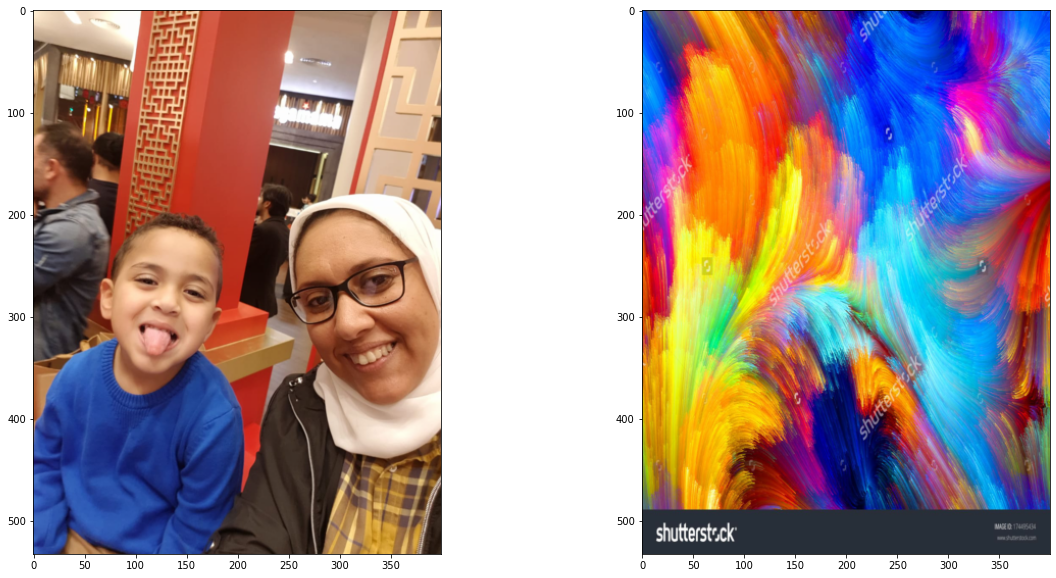

Finished Preparing Model...
Starting Training Style Transfer using content_weight 2 , style_weight2 , lr 0.003 , epochs 12000 , show_every 3000 
Current Epoch: 3000 ,Content loss: 3.8130462169647217 ,Style loss:2.8714849948883057  ,Total loss: 13.369062423706055


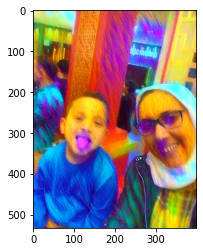

Current Epoch: 6000 ,Content loss: 3.282675266265869 ,Style loss:1.939522385597229  ,Total loss: 10.444395065307617


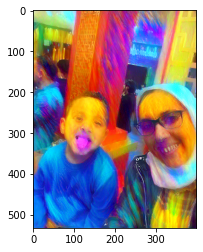

Current Epoch: 9000 ,Content loss: 3.0749545097351074 ,Style loss:1.7975659370422363  ,Total loss: 9.745040893554688


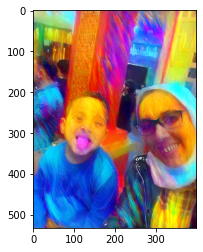

Current Epoch: 12000 ,Content loss: 3.002714157104492 ,Style loss:1.7558321952819824  ,Total loss: 9.51709270477295


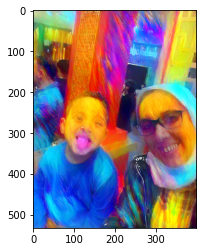

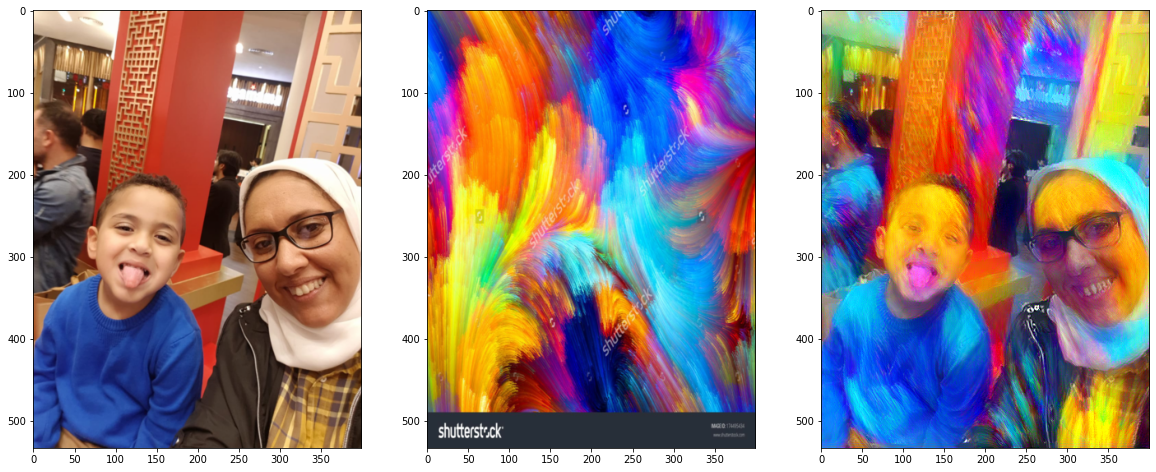

PIL converted to b64 in 0.113 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.089 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.066 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.098 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.047 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


127.0.0.1 - - [23/Apr/2020 19:24:27] "POST /_dash-update-component HTTP/1.1" 200 -


PIL converted to b64 in 0.045 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.045 sec
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
PIL converted to b64 in 0.045 sec


127.0.0.1 - - [23/Apr/2020 19:28:53] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 1 
isStyleAlreadyRun -> already_run: True
isStyleAlreadyRun -> already_run: True
Target Images Slider Index : Style.jpg 
PIL converted to b64 in 0.062 sec


127.0.0.1 - - [23/Apr/2020 19:29:08] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 2 
isStyleAlreadyRun -> already_run: True
isStyleAlreadyRun -> already_run: True
Target Images Slider Index : Style-1.jpg 
PIL converted to b64 in 0.048 sec


127.0.0.1 - - [23/Apr/2020 19:29:18] "GET /download/Style-1.jpg HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2020 19:30:05] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 4 
isStyleAlreadyRun -> already_run: True
isStyleAlreadyRun -> already_run: True
Target Images Slider Index : Style-3.jpg 
PIL converted to b64 in 0.046 sec


127.0.0.1 - - [23/Apr/2020 19:30:15] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 5 
isStyleAlreadyRun -> already_run: True
isStyleAlreadyRun -> already_run: True
Target Images Slider Index : Style-4.jpg 
PIL converted to b64 in 0.045 sec


127.0.0.1 - - [23/Apr/2020 19:30:21] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email mohamed.phd011@gmail.com ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 6 
isStyleAlreadyRun -> already_run: True


127.0.0.1 - - [23/Apr/2020 19:31:11] "POST /_dash-update-component HTTP/1.1" 200 -


update_output ['faces.jpg', 'z34.jpg'] , resetbtn_click 1 , upload_dir_exist True 


127.0.0.1 - - [23/Apr/2020 19:31:11] "POST /_dash-update-component HTTP/1.1" 200 -


handle_start_image_style -> no_startBtn_click 1 ,user_email  ,finishUserInfoBtn 1 ,content_weight_slider 2,style_weight_slider 2,learning_rate_slider 3, epochs_slider 6 ,show_every_slider 3 ,target_images_slider 6 
isStyleAlreadyRun -> already_run: False


In [0]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import json
from dash.exceptions import PreventUpdate
import shutil
import time
from datetime import datetime as dt
from google.colab import drive
import pdb

#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

#app = dash.Dash(__name__, external_stylesheets=external_stylesheets)


HTML_IMG_SRC_PARAMETERS = 'data:image/png;base64, '
UPLOAD_DIRECTORY = "./cached_images/"
G_DRIVE_PATH = f'/content/gdrive/My Drive/Colab Notebooks/models/styling/'
STYLED_IMAGE_NAME = 'Final.jpg'
CONTENT_IMAGE_NAME = 'Original.jpg'
STYLE_IMAGE_NAME = 'Style.jpg'
EXE_LOG_FILE = 'log.txt'

slider_labels = ['Default','Small','Large','Max']
target_slider_labels = ['Original','Style','Style-1','Style-2','Style-3','Style-4','Style-5','Style-6','Style-7','Final']
content_weight_data = [1,2,3,4]
style_weight_data = [1,2,3,4] #[3,4,5,6]
learning_weight_data=[3,30,300,600]
epochs_data=[2,4,6,8]
show_every_data=[1,2,3,4]
#app.config['suppress_callback_exceptions']=True

def uploaded_files():
    """List the files in the upload directory."""
    files = []
    for filename in os.listdir(UPLOAD_DIRECTORY):
        path = os.path.join(UPLOAD_DIRECTORY, filename)
        if os.path.isfile(path):
            files.append(filename)
    return files

def file_download_link(filename):
    """Create a Plotly Dash 'A' element that downloads a file from the app."""
    location = "/download/{}".format(urlquote(filename))
    return html.A(filename, href=location)

def save_images(name,content,currentStyleId='',gDrive=False):
    
    full_path_local_gdrive = []
    """Decode and store a file uploaded with Plotly Dash."""
    data = content.encode("utf8").split(b";base64,")[1]

    if(gDrive):
      drive.mount('/content/gdrive')
      full_path_local_gdrive.append(UPLOAD_DIRECTORY)
      full_path_local_gdrive.append(os.path.join(G_DRIVE_PATH, currentStyleId))
    else:
      full_path_local_gdrive.append(os.path.join(UPLOAD_DIRECTORY, currentStyleId))

    for full_path in full_path_local_gdrive:
      if not os.path.exists(full_path):
        os.makedirs(full_path) 
      full_path = os.path.join(full_path, name)

      with open(full_path, "wb") as fp:
        fp.write(base64.decodebytes(data))

    return os.path.join(full_path_local_gdrive[0], name)

def display_original_images(contents, filename):
    print('display_original_images ....')
    return html.Li(
        children=[ dcc.Link(href='#'+filename,
            children=[
                      html.Img(id=filename,src=contents),
                      html.Div(className='box_data',
                        children=[html.Span(filename)]
                      )
            ]
        )
                  
        ]
    )

def get_img_for_html(path):
  img = im_convert(load_image(path, max_size=400, shape=None))
  return HTML_IMG_SRC_PARAMETERS + numpy_to_b64(img)

def isStyleAlreadyRun():
  # due to lack of dash to reset button clicks , so will check if already start_styling called before using generated & saved images
        #os.path.exists(UPLOAD_DIRECTORY+target_slider_labels[2]+'.jpg')
  #already_run = len([name for name in os.listdir(UPLOAD_DIRECTORY) if os.path.isfile(name)]) > 2
  total_files=0
  for root, dirs, files in os.walk(UPLOAD_DIRECTORY):
    for fname in files:
      total_files+=1

  print('isStyleAlreadyRun -> already_run: {}'.format(total_files > 2))
  return total_files > 2

def record_new_exe(user_email,exe_id,content_weight_slider,style_weight_slider,learning_rate_slider,epochs_slider,show_every_slider):
  with open(G_DRIVE_PATH+EXE_LOG_FILE, "a") as myfile:
    print('record_new_exe -> exe_id {} ,user_email {} ,content_weight_slider {} ,style_weight_slider {} ,learning_rate_slider {} ,epochs_slider {} ,show_every_slider {} '.format(exe_id,user_email,content_weight_slider,style_weight_slider,learning_rate_slider,epochs_slider,show_every_slider))
    myfile.write('\n{};{};{};{};{};{};{};'.format(exe_id,user_email,content_weight_slider,
                                                  style_weight_slider,learning_rate_slider,epochs_slider,show_every_slider))

def init_gallery():
  drive.mount('/content/gdrive')
  galleryPath= G_DRIVE_PATH
  children = []
  for root, dirs, files in os.walk(galleryPath):
    for fname in files:
      dir_list = root.split(os.sep)
      image_id = dir_list[len(dir_list)-1]+'_'+fname 
      if(fname == STYLED_IMAGE_NAME):
        print('InitGallery .... Final-Image : {} '.format(image_id))
        children.append(
            html.Li(
                children=[ dcc.Link(href='#'+image_id,
                    children=[
                              html.Img(id=image_id,src=get_img_for_html(root+'/'+fname) ),
                              html.Div(className='box_data',
                                children=[html.Span(image_id)]
                              )
                    ]
                )
                          
                ]
            )
          ) 

  return children

def build_layout(app):
  app.scripts.config.serve_locally = True
  app.css.config.serve_locally = True

  app.layout = html.Div(id='please_wait', children=[ #className='modal-container', children=[
                html.Div( #className='modal-content',
      children=[
          html.H1("Hi There , Enjoy Below Stlylish Images..."),
          html.Ul( className='gallery_box',
            children= init_gallery()
          ),

          html.H1("Wanna Try Styling Your Images !!! , Go Ahead & Pickup Them...."),
          html.Button('Lets Start Upload Your Pix !',id='startUploadButton', className='trigger', style={
                                                                          "background" : "#fbe912",
                                                                          "padding" : "19px;color: #fff"
                                                                          }),   

          html.Div(id='uploadModal' ,className='modal-container',children=[
            html.Div(className='modal-content',children=[
                html.H2("Upload Images To Style"),
                dcc.Upload(
                    id="upload-data",
                    children=html.Div(
                        ["Drag and drop or click to select a file to upload."]
                    ),
                    style={
                        "width": "100%",
                        "height": "60px",
                        "lineHeight": "60px",
                        "borderWidth": "1px",
                        "borderStyle": "dashed",
                        "borderRadius": "5px",
                        "textAlign": "center",
                        "margin": "10px",
                    },
                    multiple=True,
                ),
                html.Button('Upload !',id='closeUploadButton', className='close-button'),
            ])
          ]),
          
          html.Ul( className='gallery_box',
          children= [html.Div(id='content_style_original_images',className='mb-3 pics animation all 2')]),

          html.Button('Wanna More Control!', id='startSettingsBtn' , className='trigger', style={
                                                                          "background" : "#fbe912",
                                                                          "padding" : "19px;color: #fff"
                                                                          }),
          html.Div(id='settingsModal',className='modal-container',children=[
                html.Div(className='modal-content',children=[
                          html.H5('Content Image Weight%'),
                          dcc.Slider(
                              id = 'content_weight_slider',
                              min = min(content_weight_data),
                              max = max(content_weight_data),
                              value = min(content_weight_data),
                              marks = { content_weight : label for content_weight,label in zip(content_weight_data,slider_labels) },
                              step=None
                          ),
                          html.H5('Style Image Weight%'),
                          dcc.Slider(
                              id = 'style_weight_slider',
                              min = min(style_weight_data),
                              max = max(style_weight_data),
                              value = max(style_weight_data),
                              marks = { style_weight : label for style_weight,label in zip(style_weight_data,slider_labels) },
                              step=None
                          ),
                          html.H5('Learning Rate'),
                          dcc.Slider(
                              id = 'learning_rate_slider',
                              min = min(learning_weight_data),
                              max = max(learning_weight_data),
                              value = min(learning_weight_data),
                              marks = { learning_weight : label for learning_weight,label in zip(learning_weight_data,slider_labels) },
                              step=None
                          ),
                          html.H5('Repitions '),
                          dcc.Slider(
                              id = 'epochs_slider',
                              min = min(epochs_data),
                              max = max(epochs_data),
                              value = min(epochs_data),
                              marks = { epochs_weight : label for epochs_weight,label in zip(epochs_data,slider_labels) },
                              step=None
                          ),
                          html.H5('Print Inner Images Interval'),
                          dcc.Slider(
                              id = 'show_every_slider',
                              min = min(show_every_data),
                              max = max(show_every_data),
                              value = min(show_every_data),
                              marks = { show_every_weight : label for show_every_weight,label in zip(show_every_data,slider_labels) },
                              step=None
                          ),
                          html.Button('Done !', id='finishSettingsBtn' , className='close-button'),

                        ]),
          ]),
      
          #html.Button('Start Styling', id='startBtn'),
          html.Button('Reset Styling', id='resetBtn', style={
                                                                          "background" : "#fbe912",
                                                                          "padding" : "19px;color: #fff"
                                                                          }),
          # CACHING INNER IMMGES
          html.Div(id='cached_inner_images', style={'display': 'none'}),
          #dcc.Store(id='cached_inner_images', storage_type='local'),
      
          html.Div(id='target_images_slider_div', className='modal-container',
                  children=[               
                    html.Div( className='modal-content',
                            children=[
                              html.Div(id='target_images'),
                              html.H5('Target Images'),
                              dcc.Slider(
                                  id = 'target_images_slider',
                                  min = 0,
                                  max = 10,
                                  value = 0,
                                  marks = { index : label for index,label in zip(range(len(target_slider_labels)),target_slider_labels) },
                                  step=None
                              ),
                              html.Button('Cool !', id='finishImagesSlider', className='trigger'),      
                            ]),
                  ]),
                
          html.Button('Lets Go!', id='startBtn' , className='trigger', style={
                                                                          "background" : "#fbe912",
                                                                          "padding" : "19px;color: #fff"
                                                                          }),      
          html.Div(id='user_info_modal', className='modal-container',children=[
            html.Div( className='modal-content',
                    children=[
                              html.Div(id='user_info_popup', className='modal-content',
                                      children=[
                                        html.H5('Hi , Input Some Data Before Start ...'),
                                        dcc.Input( id='user_email' , type='email', placeholder='type your email please',debounce=True),
                                        html.Button('Finish', id='finishUserInfoBtn' , className='close-button'),
                                      ])
                              ])
            ])
          #html.H2("File List"),
          #html.Ul(id="file-list"),
      
      ])
      #style={"max-width": "500px"},
  ])
  

  return app

def init_dash_app(server):

  external_stylesheets = []#'//maxcdn.bootstrapcdn.com/bootstrap/4.0.0/css/bootstrap.min.css']
  external_scripts = []#'//maxcdn.bootstrapcdn.com/bootstrap/4.0.0/js/bootstrap.min.js',
                      #'//cdnjs.cloudflare.com/ajax/libs/jquery/3.2.1/jquery.min.js']

  ### Get the public URL where you can access the Dash app. Copy this URL.
  #print('PUBLIC IP.....')
  ! curl -s http://localhost:4040/api/tunnels | python3 -c \
      "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

  app = dash.Dash(server=server,
                  external_stylesheets=external_stylesheets,
                  external_scripts=external_scripts)

  if os.path.exists(UPLOAD_DIRECTORY):
    shutil.rmtree(UPLOAD_DIRECTORY)

  app = build_layout(app)

  return app

app = init_dash_app(server)

@app.server.route('/assets/<path:path>')
def static_file(path):
    static_folder = os.path.join(os.getcwd(), 'assets')
    return send_from_directory(static_folder, path)

@server.route("/download/<path:path>")
def download(path):
    """Serve a file from the upload directory."""
    return send_from_directory(UPLOAD_DIRECTORY, path, as_attachment=True)
#############################################
# CONTENT-STYLE IMAGES 
#############################################
@app.callback(
    [Output("content_style_original_images", "children"),
      Output("uploadModal", "className"),
      Output('user_email', 'value')],
    [Input("upload-data", "filename"), 
     Input("upload-data", "contents"),
     Input('resetBtn', 'n_clicks')]
)
def update_content_style_original_images(uploaded_filenames, uploaded_file_contents,resetBtn_click):
    """Save uploaded files and regenerate the file list."""

    children  = []
    global gModel

    print('update_output {} , resetbtn_click {} , upload_dir_exist {} '.format(uploaded_filenames,resetBtn_click,os.path.exists(UPLOAD_DIRECTORY)))
    if uploaded_filenames is not None and uploaded_file_contents is not None and not os.path.exists(UPLOAD_DIRECTORY):
        os.makedirs(UPLOAD_DIRECTORY)
        for id,name, data in zip(range(len(uploaded_filenames)),uploaded_filenames, uploaded_file_contents):
            if(id == 0):
              name = CONTENT_IMAGE_NAME
            elif(id == 1):
              name = STYLE_IMAGE_NAME
            else:
              continue

            save_images(name, data)
            print('uploaded image index: ',id,' At Path: ',UPLOAD_DIRECTORY+name)
            children.append( display_original_images(data, name))
        return children , 'modal-container      ' , ''

    # HANDLE RESET
    if( resetBtn_click is not None and os.path.exists(UPLOAD_DIRECTORY)):
      shutil.rmtree(UPLOAD_DIRECTORY)
      gModel = None
      return [] , 'modal-container     ',''
 
    return [] , 'modal-container      ',''

#############################################
# START STYLING & INNER_IMAGES SLIDER
#############################################
@app.callback(
    [Output("target_images", "children"),
     Output("target_images_slider_div", "className")
     ],
    [Input('startBtn', 'n_clicks'),
     Input('user_email', 'value'),
     Input('finishUserInfoBtn', 'n_clicks'),
     Input('content_weight_slider','value'),
     Input('style_weight_slider','value'),
     Input('learning_rate_slider','value'),
     Input('epochs_slider','value'),
     Input('show_every_slider','value'),
     Input('target_images_slider','value'),],
)
def handle_start_image_style(no_startBtn_click,user_email,finishUserInfoBtn,content_weight_slider,style_weight_slider,learning_rate_slider,
                    epochs_slider,show_every_slider,target_images_slider):
    
    global gModel

    print('handle_start_image_style -> no_startBtn_click {} ,user_email {} ,finishUserInfoBtn {} ,content_weight_slider {},style_weight_slider {},learning_rate_slider {}, epochs_slider {} ,show_every_slider {} ,target_images_slider {} '.format(no_startBtn_click,user_email,finishUserInfoBtn,content_weight_slider,style_weight_slider,learning_rate_slider, epochs_slider,show_every_slider,target_images_slider))
    # HANDLE CLICK
    if( no_startBtn_click is not None and gModel is None and not isStyleAlreadyRun() ):
      if(user_email is None or user_email == '' or finishUserInfoBtn is None or  finishUserInfoBtn == 0):
        return [] , "modal-container"

      currentStyleId = dt.now().strftime("%d_%b_%Y_%H_%M_%S")
      epochs_slider = epochs_slider * 2000
      show_every_slider = show_every_slider * 1000
      learning_rate_slider = learning_rate_slider/1000
      style_weight_slider = style_weight_slider #10 ** style_weight_slider
      content_weight_slider = content_weight_slider #10 ** content_weight_slider # content_weight_slider/2

      record_new_exe(currentStyleId,user_email,content_weight_slider,style_weight_slider,learning_rate_slider,epochs_slider ,show_every_slider)

      target, cached_inner_images = RunModel(UPLOAD_DIRECTORY+CONTENT_IMAGE_NAME,UPLOAD_DIRECTORY+STYLE_IMAGE_NAME,content_weight_slider,style_weight_slider, learning_rate_slider, epochs_slider , show_every_slider )
      if not os.path.exists(UPLOAD_DIRECTORY):
        os.makedirs(UPLOAD_DIRECTORY)
      
      
      # save inner images to desk , due to memory/cach limitation
      for id , content in zip(range(len(cached_inner_images)),cached_inner_images):
        fname=''
        if(id == 0):
          fname = CONTENT_IMAGE_NAME
        elif(id == 1):
          fname = STYLE_IMAGE_NAME  
        elif(id == len(cached_inner_images)-1):
          fname = STYLED_IMAGE_NAME
        else:
          fname = target_slider_labels[id]+'.jpg'          
        save_images(fname, HTML_IMG_SRC_PARAMETERS + numpy_to_b64(content),currentStyleId,True)
      
      gModel = None
      return html.Div([                    
                html.Img(src=HTML_IMG_SRC_PARAMETERS + numpy_to_b64(target)), 
                ]) , "modal-container show-modal"
      
    selected_slider_image_name = target_slider_labels[target_images_slider]+'.jpg'
    # HANDLE INNER IMAGES SLIDER
    if( target_images_slider is not None and os.path.exists(UPLOAD_DIRECTORY+selected_slider_image_name) and isStyleAlreadyRun()):
      #inner_images = json.loads(cached_inner_images)
      print('Target Images Slider Index : {} '.format(selected_slider_image_name))
      cached_img_path = UPLOAD_DIRECTORY+selected_slider_image_name
      #cached_inner_image = im_convert(load_image(cached_img_path, max_size=400, shape=None))
      
      download_location = "/download/{}".format(urlquote(selected_slider_image_name))

      return html.Div([                    
                html.Img(src=get_img_for_html(cached_img_path),),#style={'height':'50%', 'width':'50%'}),
                html.A('You Like it ? So Go Recieve It over the Mail...', href=download_location)
                ]
                ) , "modal-container show-modal"
    
    return [] , "modal-container"           




if __name__ == "__main__":
  app.run_server(debug=False, port=8050)